# Vision - Unsupervised Domain Adaptation by Backpropagation


By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of the paper - [*Unsupervised Domain Adaptation by Backpropagation*](https://arxiv.org/pdf/1409.7495.pdf) by *[Yaroslav Ganin](http://yaroslav.ganin.net/#) et. al.* using PyTorch.

First we'll train the a model on source dataset => MNIST. Then we'll compare it's performance on the target => MNISTM. Then we'll train another model using domain adaptation and test it again on MNISTM. 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split


from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

root_dir = "../../../data/computer_vision/domain_adaptation/Mnist2MnistM/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../../../data/computer_vision/domain_adaptation/Mnist2MnistM/


In [5]:
os.listdir(root_dir)

['mnistM', 'mnist']

## Load MNIST and MNIST-M Data

In [6]:
mnist_dir = root_dir + "mnist/"
mnist_m_dir = root_dir + "mnistM/"

### Convert Images to Tensor

In [11]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
}

### Create Dataset

In [12]:
# mnist
mnist_dataset_train = datasets.ImageFolder(root = mnist_dir + "train",
                                           transform = image_transforms["train"]
                                          )

mnist_dataset_test = datasets.ImageFolder(root = mnist_dir + "test",
                                           transform = image_transforms["test"]
                                          )


# mnistM
mnist_m_dataset_train = datasets.ImageFolder(root = mnist_m_dir + "train",
                                             transform = image_transforms["train"]
                                            )

mnist_m_dataset_test = datasets.ImageFolder(root = mnist_m_dir + "test",
                                            transform = image_transforms["test"]
                                           )

### Create Dataloader

In [13]:
# mnist
mnist_loader_train = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=128, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=False)

# mnistM
mnist_m_loader_train = torch.utils.data.DataLoader(mnist_m_dataset_train, batch_size=128, shuffle=True)
mnist_m_loader_test = torch.utils.data.DataLoader(mnist_m_dataset_test, batch_size=1, shuffle=False)

### Explore Data

#### MNIST

In [14]:
single_batch = next(iter(mnist_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([128, 3, 28, 28])
Output labels:  torch.Size([128])


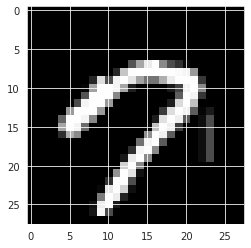

In [15]:
plt.imshow(images[0].permute(1, 2, 0))

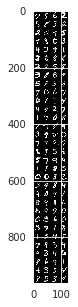

In [16]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

#### MNIST-M

In [17]:
single_batch = next(iter(mnist_m_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([128, 3, 28, 28])
Output labels:  torch.Size([128])


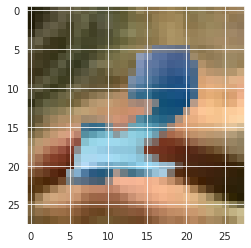

In [18]:
plt.imshow(images[0].permute(1, 2, 0))

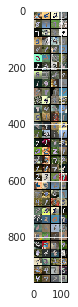

In [19]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## TRAIN on MNIST [Source]

### Model Definition

In [20]:
class ModelMnistSource(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelMnistSource, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )
        
        self.fc = nn.Linear(32*28*28, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [21]:
model_mnist = ModelMnistSource()
print(f"We're using {device}.\n")
model_mnist.to(device)
print(model_mnist)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=0.001)

We're using cuda.

ModelMnistSource(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)


In [22]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

### Train

In [23]:
EPOCHS = 3

for e in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model_mnist.train()
    for X_train_batch, y_train_batch in mnist_loader_train:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model_mnist(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(mnist_loader_train):.5f} | Train Acc: {train_epoch_acc/len(mnist_loader_train):.3f}')

Epoch 001: | Train Loss: 0.27925 | Train Acc: 98.294
Epoch 002: | Train Loss: 0.09664 | Train Acc: 100.000
Epoch 003: | Train Loss: 0.06600 | Train Acc: 100.000



### Test

In [24]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [28]:
print("Trained on MNIST | Tested on MNIST. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST. 


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       980
           1       0.98      1.00      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Test on MNIST-M [Target]

Now, let's test our model on the target dataset, ie. MNIST-M.

To do that, we need to load the data first.

In [29]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [33]:
print("Trained on MNIST | Tested on MNIST-M. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST-M. 


              precision    recall  f1-score   support

           0       0.86      0.45      0.59       878
           1       0.62      0.58      0.60      1016
           2       0.46      0.56      0.50       933
           3       0.56      0.44      0.49       908
           4       0.92      0.32      0.47       890
           5       0.36      0.65      0.47       807
           6       0.86      0.42      0.56       856
           7       0.51      0.47      0.49       914
           8       0.74      0.43      0.54       880
           9       0.30      0.72      0.42       919

    accuracy                           0.50      9001
   macro avg       0.62      0.50      0.51      9001
weighted avg       0.62      0.50      0.51      9001



**As we see from the results above, our model trained on MNIST performs horribly for MNIST-M.**

> Let's see some of that unsupervised domain adaption now.

In [32]:
\

'ol'